In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

data = pd.read_excel (r'C:\Users\callu\Dropbox\03ShOpen1mmGBon_29.38mK_BB3.21.xlsx')

In [3]:
def f(x, A, B):
    ''' 
    Function of straight line for optimisation function to find
    coefficients for.
    '''
    return A*x + B


In [9]:
class TES(object):
    '''
    '''
    # initialise with raw IV data and maybe other params?
    def __init__(self, rawIV, params=0): 
        self.rawIV = rawIV
        self.params = params
        
        self.y_offset = 0
        self.rnn = 0
        
        # Values hard coded (for now) taken from spreadsheet
        self.R_fb = 100099.6
        self.M_ratio = 18.9333333333333
                
        self.gain = 1 / (self.R_fb * self.M_ratio)
        
        self.R_shunt = 0.00389
        self.R_stray = 0.0005
        
    def identify_regions(self, data, threshold):
        '''
        This function accepts a data frame and a threshold to compare the 
        gradient to. Checks either side of data set and identifies regions
        before the spikes.
        Returns a tuple of indices which correspond to the ranges we are 
        interested in
        #TODO Find out what threshold is justified
        '''
        front = 0 
        back = 0 
        threshold = int((len(data)/100) * threshold)
        print('Number of disregarded entries: '+ str(threshold))
        grad = np.gradient(data.iloc[:, 1]) #Gradient of the Voltages
        for i in range(len(data)): 
            if grad[i] <= 0:#Check from the start until grad 
                front = i - threshold         #hits the threshold then store index
                break
        for n in range(len(data)):
            if grad[-n] <= 0:
                back = len(data) - n + threshold
                break
        return front , back

    # A,B = curve_fit(f, data['bias'], data['V fb (V)'])[0]
    def fitLine(self, inputdata, region):
        ''' 
        Accepts a data frame and a tuple of indices. These are then used 
        to fit a straight line to the straight regions and plots the
        line with the data in the frame. 
        Returns nothing.
        #TODO Generalise!!
        '''
        front , back = region # Unpack data ranges from region

        firstx = (inputdata.iloc[:, 0]).values[0]
        lastx = (inputdata.iloc[:, 0]).values[-1]
        

        xvals = np.linspace(firstx, lastx)

        #Slice the data in the frame and store in an array 
        yvals1 = (inputdata.iloc[:,1]).values[:front]
        yvals2 = (inputdata.iloc[:,1]).values[back:]
        lineDataY = np.append(yvals1, yvals2)
        
        xvals1 = (inputdata.iloc[:,0]).values[:front]
        xvals2 = (inputdata.iloc[:,0]).values[back:]

        lineDataX = np.append(xvals1, xvals2)
        
        print("Regions")
        print(front, back)
        #print("LinedataX : " + str(lineDataX))


        #fit the sliced data to a line
        C, D = curve_fit(f, lineDataX, lineDataY)[0]

        return C , D , xvals
    
    def calc_y_offset(self, thresholdPercentage):
        '''
        Input: Threshold percentage (int)
        OutPut: D (float)
        '''
        ranges = self.identify_regions(self.rawIV, thresholdPercentage)
        C, D , xvals = self.fitLine(self.rawIV, ranges)
        self.y_offset = D
        #print("y offset: " + str(D))
        self.rawXvals = xvals
        
    def calc_I_TES(self, tweak=1):
        '''
        Generate I_tes (array) data from tweak(float), y_offset (float)
        , gain (float).
        
        tweaks not yet used
        '''
        #TODO generate 
        self.I_TES = [(entry - self.y_offset) * 10**6 * self.gain for entry in self.rawIV['V fb (V)']]
        
    def calc_V_bias(self, tweak=1):
        '''
        Generates B_bias data
        '''
        self.V_bias = []
        for index in range(len(data)):
            self.V_bias.append((data['bias'][index] * self.R_shunt) - (self.I_TES[index]*(self.R_shunt + self.R_stray)))
        
    def plotIV(self):
        '''
        
        '''
        #plt.plot(self.V_bias, self.I_TES)
        analysed_IV = pd.DataFrame(
            {'V': self.V_bias,
             'I_TES': self.I_TES,
            })
        regions = self.identify_regions(analysed_IV, 10)

        C, D , Axvals = self.fitLine(analysed_IV, regions)
        
        self.rnn = 1/C
        
        fig, ax = plt.subplots()
        
        plt.plot(Axvals, f(Axvals, C , D), label='Load Line')
        #plt.axhline(y=0)
        #plt.axvline(x=0)
        plt.grid()
        plt.plot(self.V_bias, self.I_TES, label='TES IV')
        ax.set_xlabel("Voltage (mV)")
        ax.set_ylabel("TES Current (mA)")
        plt.title("Calibrated IV Curve")
        ax.legend()
        #plt.plot(lineDataX, lineDataY)
        
    def calc_P_TES(self):
        self.P_TES = [self.I_TES[index] * self.V_bias[index] for index in range(len(self.I_TES))]

    def plotPV(self):
        fig, ax = plt.subplots()
        plt.grid()
        plt.plot(self.V_bias, self.P_TES, label='TES PV')
        plt.title("Power Curve")
        ax.set_xlabel("Voltage (mV)")
        ax.set_ylabel("TES Power (fW)")
        
        readout = self.constLine(self.P_TES, (max(self.P_TES)/500))
        
        plt.plot(self.V_bias, [readout for entry in self.V_bias], label=readout)
        
        plt.legend()
        

    def constLine(self, data, margin):
        '''
        Trying to optimise a line of y = const to read off the power from the graph.
        Accepts a set of data (power values) and a step size, which doubles as the margin.
        Returns the y value which corresponds to the most values from the power graph.

        #TODO make more robust. maybe make it find the largest x range rather than just hits

        This is currently a niave implementation  but it works under the assumption that there will be 
        either uniform readings or higher concentration around 0. Currently -ve values of P are disregarded to 
        '''
        ys = []
        counts = []
        y = 0
        while y < max(data):
            y1 = y - margin
            y2 = y + margin
            count = 0
            for entry in data:
                if entry > 0 and entry > y1 and entry < y2:
                    count += 1
            counts.append(count)
            ys.append(y)
            y += margin
        npcounts = np.array(counts)
        ind = np.argmax(npcounts)
        return ys[ind]
    
    def calc_R_TES(self):
        self.R_TES = [self.V_bias[i] / self.I_TES[i] for i in range(len(self.V_bias))]

    def plotPR(self):
        fig, ax = plt.subplots()
        plt.grid()
        plt.plot(self.R_TES, self.P_TES, label='TES PR')
        plt.title("Power vs Resistance Curve")
        ax.set_xlabel("TES Resistance (ohm)")
        ax.set_ylabel("TES Power (fW)")

        readout = self.constLine(self.P_TES, (max(self.P_TES)/500))

        plt.plot(self.R_TES, [readout for entry in self.R_TES], label=readout)

        plt.legend()
        
    def calc_superconducting(self):
        differences = []
        
        for idx in range(len(self.V_bias) - 1):
            differences.append(self.I_TES[idx] - self.I_TES[idx + 1])
        rangeI = max(self.I_TES) - min(self.I_TES)
        print(max(differences))
        if max(differences) >= rangeI / 10:
            self.superconducting = True
        else:
            self.superconducting = False
            
        return self.superconducting
    
    ##################################################################################################
    ## Possible future functions
    def smooth_IV():
        #TODO
        ''' Maybe a function to smooth noisy data before we find the 
        y offset. 
        Inputs: rawIV (or just use self?)
        Outputs: stores smoothRawIV in self
        '''
        pass
    
    def find_threshold():
        '''
        Will find the most optimal threshold to use for the region finding
        '''
        
        pass 

In [10]:
TESt = TES(data)
for i in range(15):
    print(i)
    TESt = TES(data)
    TESt.calc_y_offset(i)
    print(TESt.y_offset)
    TESt.calc_I_TES()
    TESt.calc_V_bias()
    #TESt.plotIV()
    plt.show()
    print(TESt.rnn)



0
Number of disregarded entries: 0
Regions
108 238
0.00025259260377319404
0
1
Number of disregarded entries: 3
Regions
105 241
0.00018499245302272538
0
2
Number of disregarded entries: 6
Regions
102 244
0.0001369958812502379
0
3
Number of disregarded entries: 10
Regions
98 248
9.784714786431614e-05
0
4
Number of disregarded entries: 13
Regions
95 251
8.023070499807439e-05
0
5
Number of disregarded entries: 17
Regions
91 255
5.980934906169022e-05
0
6
Number of disregarded entries: 20
Regions
88 258
5.4142551020541774e-05
0
7
Number of disregarded entries: 24
Regions
84 262
4.848120864320293e-05
0
8
Number of disregarded entries: 27
Regions
81 265
4.779935728038698e-05
0
9
Number of disregarded entries: 31
Regions
77 269
5.19690733669087e-05
0
10
Number of disregarded entries: 34
Regions
74 272
6.008326673401232e-05
0
11
Number of disregarded entries: 38
Regions
70 276
7.396509458346134e-05
0
12
Number of disregarded entries: 41
Regions
67 279
8.699101084463923e-05
0
13
Number of disrega

Biggest conceptual problem is how to reliably choose a threshold.
What to do next:
Find a way of finding the best threshold and investigate cutting off the front and back too.

Calculated Rnn = 0.10121321421622317


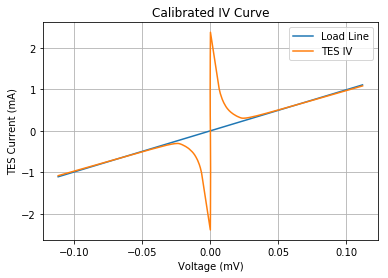

In [157]:
TESt.plotIV()
print("Calculated Rnn = " + str(TESt.rnn))

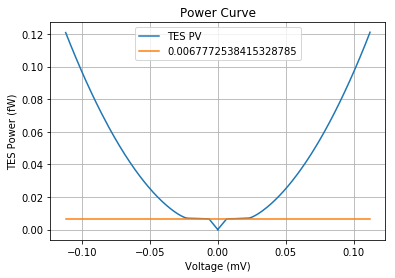

In [158]:
TESt.calc_P_TES()
TESt.plotPV()

    Things to do:
    (0) Find which thresholds work best, maybe write a function to pick the best?
    
    (1) Try test cases where there is no superconductivity and find a way to deal with those. (look for --ve to ++ve in data or use a nueral net for the fun of it)
    Turns out it analyses the data fine. Does produce readoff lines when it shouldnt though. Made a test to see if superconducting. Seems to work on simple cases. 
    
    (2) Re-check the gradient of the raw data. The gradient doesn't start constant, so maybe snip some off the front too? Does it make a difference?
    
    
    (3) I'm currently storing data in dataframes and ranges, as well as standard lists. This should be standardised. Also prefer np arrays over lists.
    Ok using pure vanilla lists is actually faster as otherwise I'm just converting to np for no reason. The code is also a lot easier to read when they are normal lists. Output could still be made into a dataframe, however. 
    
    (4) Look at the perl scipts
    (5) Build in noise resistance, smooth the curve?
    (6) Find efficiency improvements 

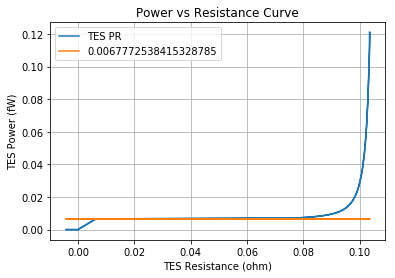

In [159]:
TESt.calc_R_TES()
TESt.plotPR()

In [160]:
data2 = pd.read_excel (r'C:\Users\callu\Dropbox\University\Year 3\Block 2b\Project\_C04P03ShClosed_44.66mK_BB3.20K.xlsx')

-0.0001982451649702751


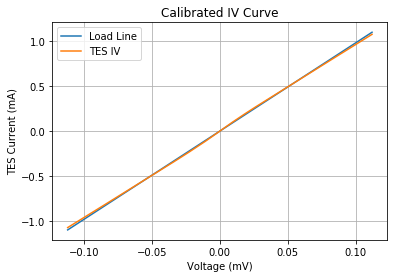

In [161]:
TESt2 = TES(data2)

TESt2.calc_y_offset(8)
print(TESt2.y_offset)
TESt2.calc_I_TES()
TESt2.calc_V_bias()
TESt2.plotIV()

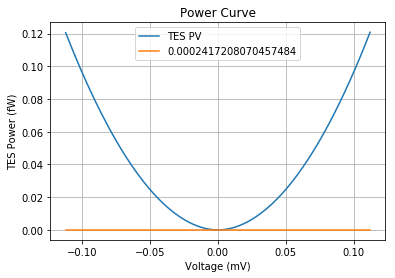

In [162]:
TESt2.calc_P_TES()
TESt2.plotPV()

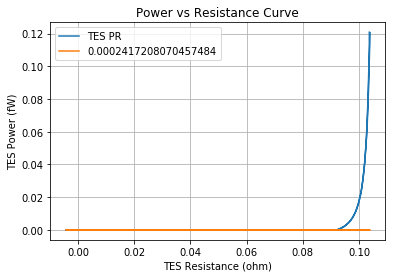

In [163]:
TESt2.calc_R_TES()
TESt2.plotPR()

In [148]:
TESt.calc_superconducting()
TESt2.calc_superconducting()
print(TESt.superconducting)

1.372247967872593
-0.0030658553147966394
True
